In [591]:
import io
import os
import sys
import string
import numpy as np
import pandas as pd

from tensorflow import keras
from __future__ import print_function
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Embedding
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import statistics
from keras.models import load_model

[nltk_data] Downloading package stopwords to C:\Users\Yesim
[nltk_data]     Kebabcı\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Yesim
[nltk_data]     Kebabcı\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# LYRICS GENERATOR USING LSTM (with tiktok trend songs)  

## Data preparation

I will use TikTok trend songs from 2020 to 2022. Year column is added to dataframes.

In [381]:
tiktok2020 = pd.read_csv('C:/Users/Yesim Kebabcı/Downloads/lstm/TikTok_songs_2020.csv')           
tiktok2021 =  pd.read_csv('C:/Users/Yesim Kebabcı/Downloads/lstm/TikTok_songs_2021.csv')    
tiktok2022 =  pd.read_csv('C:/Users/Yesim Kebabcı/Downloads/lstm/TikTok_songs_2022.csv')    

In [303]:
tiktok2020.head()

,track_name,artist_name,artist_pop,album,track_pop,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms
0,Say So,Doja Cat,88,Hot Pink,80,0.787,0.673,-4.583,0,11,0.1590,0.26400,0.000003,0.0904,0.779,110.962,4,237893
1,Blinding Lights,The Weeknd,93,After Hours,90,0.514,0.730,-5.934,1,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,4,200040
2,Supalonely (feat. Gus Dapperton),BENEE,67,Hey u x,63,0.862,0.631,-4.746,1,7,0.0515,0.29100,0.000209,0.1230,0.841,128.978,4,223488
3,Savage,Megan Thee Stallion,82,Suga,70,0.843,0.741,-5.609,1,11,0.3340,0.02520,0.000000,0.0960,0.680,168.983,4,155497
4,Moral of the Story,Ashe,68,Moral of the Story,76,0.572,0.406,-8.624,1,10,0.0427,0.58700,0.000004,0.1020,0.265,119.812,4,201084


In [304]:
tiktok2021.head()

,track_name,artist_name,artist_pop,album,track_pop,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms
0,STAY (with Justin Bieber),The Kid LAROI,83,STAY (with Justin Bieber),89,0.591,0.764,-5.484,1,1,0.0483,0.0383,0.000000,0.1030,0.478,169.928,4,141806
1,Peaches (feat. Daniel Caesar & Giveon),Justin Bieber,90,Justice,86,0.677,0.696,-6.181,1,0,0.1190,0.3210,0.000000,0.4200,0.464,90.030,4,198082
2,edamame (feat. Rich Brian),bbno$,72,edamame (feat. Rich Brian),77,0.815,0.848,-4.704,0,4,0.1150,0.0230,0.000162,0.0265,0.684,106.032,4,133707
3,Here's Your Perfect,Jamie Miller,65,Here's Your Perfect,77,0.558,0.454,-5.335,1,6,0.0551,0.4990,0.000000,0.1460,0.424,113.120,4,158594
4,It's You,Sezairi,57,It's You,73,0.630,0.456,-8.285,1,8,0.0317,0.5450,0.000000,0.1140,0.166,137.915,3,251440


In [305]:
tiktok2022.head()

,track_name,artist_name,artist_pop,album,track_pop,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms
0,Running Up That Hill (A Deal With God),Kate Bush,81,Hounds Of Love,95,0.629,0.547,-13.123,0,10,0.0550,0.7200,0.003140,0.0604,0.197,108.375,4,298933
1,As It Was,Harry Styles,91,As It Was,96,0.520,0.731,-5.338,0,6,0.0557,0.3420,0.001010,0.3110,0.662,173.930,4,167303
2,Sunroof,Nicky Youre,73,Sunroof,44,0.768,0.716,-5.110,1,10,0.0404,0.3500,0.000000,0.1500,0.841,131.430,4,163026
3,Heat Waves,Glass Animals,80,Dreamland (+ Bonus Levels),89,0.761,0.525,-6.900,1,11,0.0944,0.4400,0.000007,0.0921,0.531,80.870,4,238805
4,About Damn Time,Lizzo,81,About Damn Time,92,0.836,0.743,-6.305,0,10,0.0656,0.0995,0.000000,0.3350,0.722,108.966,4,191822


In [148]:
#adding year value before appending dataframes
tiktok2020['year'] = 2020
tiktok2021['year'] = 2021
tiktok2022['year'] = 2022

In [149]:
#appending - single final dataframe that includes three years
final_df = tiktok2020.append(tiktok2021, ignore_index=True)
final_df = final_df.append(tiktok2022, ignore_index = True)

C:\Users\Yesim Kebabcı\AppData\Local\Temp\ipykernel_14020\2161109058.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = tiktok2020.append(tiktok2021, ignore_index=True)


In [175]:
final_df.head(9)

,track_name,artist_name,artist_pop,album,track_pop,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms,year,chorus
0,Say So,Doja Cat,88,Hot Pink,80,0.787,0.673,-4.583,0,11,0.1590,0.26400,0.000003,0.0904,0.779,110.962,4,237893,2020,"Day to night to morning, keep with me in the m..."
1,Blinding Lights,The Weeknd,93,After Hours,90,0.514,0.730,-5.934,1,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,4,200040,2020,"I said, ooh, I'm blinded by the lights\nNo, I ..."
2,Supalonely (feat. Gus Dapperton),BENEE,67,Hey u x,63,0.862,0.631,-4.746,1,7,0.0515,0.29100,0.000209,0.1230,0.841,128.978,4,223488,2020,Supalonely ft. Gus Dapperton (Türkçe Çeviri) L...
3,Savage,Megan Thee Stallion,82,Suga,70,0.843,0.741,-5.609,1,11,0.3340,0.02520,0.000000,0.0960,0.680,168.983,4,155497,2020,"I'm a savage (Yeah)\nClassy, bougie, ratchet (..."
4,Moral of the Story,Ashe,68,Moral of the Story,76,0.572,0.406,-8.624,1,10,0.0427,0.58700,0.000004,0.1020,0.265,119.812,4,201084,2020,"Some mistakes get made\nThat's alright, that's..."
5,Rain On Me (with Ariana Grande),Lady Gaga,84,Rain On Me (with Ariana Grande),74,0.672,0.855,-3.764,1,9,0.0397,0.02100,0.000000,0.3230,0.646,123.056,4,182200,2020,
6,Babylon,Lady Gaga,84,Chromatica,64,0.698,0.799,-4.372,1,2,0.0342,0.01290,0.000005,0.2150,0.351,115.957,4,161733,2020,"Strut it out, walk a mile\nServe it, ancient-c..."
7,Replay,Lady Gaga,84,Chromatica,66,0.658,0.878,-3.875,1,1,0.1230,0.00792,0.000000,0.9440,0.683,122.015,4,186653,2020,"I don't know what to do, you don't know what t..."
8,My Oh My (feat. DaBaby),Camila Cabello,82,Romance,75,0.724,0.491,-6.024,1,8,0.0296,0.01800,0.000013,0.0887,0.383,105.046,4,170746,2020,DaBaby Lyrics1. DaBaby - Gucci Peacoat\n2. DaB...


#### Genius API is used for accessing the song lyrics. 

In [154]:
#%pip install lyricsgenius
#%pip install tqdm
from tqdm import tqdm
import lyricsgenius
genius = lyricsgenius.Genius('DavUwPXWeSxHWCmywlt8lIWdD6N32MCWmo5He2pYInAvVsZQazq6GBG_iK6NUVMG',verbose=False)

#### After receiving the token, chorus is substracted from lyrics and added to the dataframe under chorus column.

In [5]:
#final_df['chorus'] = None
for index, row in tqdm(final_df.iterrows()):
    try:# run your code
        song = genius.search_song(row['track_name'], row['artist_name'])
        lyrics = song.lyrics
        a = lyrics.find('[Chorus]')
        b = lyrics[a+9:].find('[')

        output =  lyrics[a+9:a+9+b]
        #if (final_df.at[row, "chorus"].isnull()):
        final_df.at[index, "chorus"] = output

    except Exception as e: 
        print(e)
        pass

In [ ]:
final_df.head()

,track_name,artist_name,artist_pop,album,track_pop,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms,year,chorus
0,Say So,Doja Cat,88,Hot Pink,80,0.787,0.673,-4.583,0,11,0.1590,0.26400,0.000003,0.0904,0.779,110.962,4,237893,2020,"Day to night to morning, keep with me in the m..."
1,Blinding Lights,The Weeknd,93,After Hours,90,0.514,0.730,-5.934,1,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,4,200040,2020,"I said, ooh, I'm blinded by the lights\nNo, I ..."
2,Supalonely (feat. Gus Dapperton),BENEE,67,Hey u x,63,0.862,0.631,-4.746,1,7,0.0515,0.29100,0.000209,0.1230,0.841,128.978,4,223488,2020,Supalonely ft. Gus Dapperton (Türkçe Çeviri) L...
3,Savage,Megan Thee Stallion,82,Suga,70,0.843,0.741,-5.609,1,11,0.3340,0.02520,0.000000,0.0960,0.680,168.983,4,155497,2020,"I'm a savage (Yeah)\nClassy, bougie, ratchet (..."
4,Moral of the Story,Ashe,68,Moral of the Story,76,0.572,0.406,-8.624,1,10,0.0427,0.58700,0.000004,0.1020,0.265,119.812,4,201084,2020,"Some mistakes get made\nThat's alright, that's..."


In [5]:
#data = final_df.to_numpy()
#np.save("data_final.npy", data)

## Data Preprocessing

In [642]:
numpy_data = np.load('data_final.npy',  allow_pickle=True)
columns = ["track_name"	,"artist_name",	"artist_pop",	"album"	,"track_pop",	"danceability",	"energy",	"loudness","mode",	"key",	"speechiness",	"acousticness",	"instrumentalness"	,"liveness",	"valence"	,"tempo"	,"time_signature",	"duration_ms",	"year",	"chorus"]
song_df = pd.DataFrame(numpy_data, columns= columns)

In [643]:
song_df.head()

,track_name,artist_name,artist_pop,album,track_pop,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms,year,chorus
0,Say So,Doja Cat,88,Hot Pink,80,0.787,0.673,-4.583,0,11,0.159,0.264,0.000003,0.0904,0.779,110.962,4,237893,2020,"Day to night to morning, keep with me in the m..."
1,Blinding Lights,The Weeknd,93,After Hours,90,0.514,0.73,-5.934,1,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,4,200040,2020,"I said, ooh, I'm blinded by the lights\nNo, I ..."
2,Supalonely (feat. Gus Dapperton),BENEE,67,Hey u x,63,0.862,0.631,-4.746,1,7,0.0515,0.291,0.000209,0.123,0.841,128.978,4,223488,2020,Supalonely ft. Gus Dapperton (Türkçe Çeviri) L...
3,Savage,Megan Thee Stallion,82,Suga,70,0.843,0.741,-5.609,1,11,0.334,0.0252,0.0,0.096,0.68,168.983,4,155497,2020,"I'm a savage (Yeah)\nClassy, bougie, ratchet (..."
4,Moral of the Story,Ashe,68,Moral of the Story,76,0.572,0.406,-8.624,1,10,0.0427,0.587,0.000004,0.102,0.265,119.812,4,201084,2020,"Some mistakes get made\nThat's alright, that's..."


#### Dealing with NaN values

In [644]:
song_df = song_df.dropna()

#### The chorus texts includes:

-  Punctutations 
-  Non Alphabetic words
-  Error messages 

The text is cleaned and characters are lowered for an eligible format.

In [645]:
song_df.shape

(709, 20)

In [646]:
song_df = song_df[song_df["chorus"].apply(lambda x: len(x.split()) in range (20,200) )]
song_df.shape

(379, 20)

In [647]:
chorus_length = []
song_df["chorus"].apply(lambda x: chorus_length.append(len(x.split())) )
statistics.median(chorus_length)

47

In [648]:
song_df.head()

,track_name,artist_name,artist_pop,album,track_pop,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms,year,chorus
0,Say So,Doja Cat,88,Hot Pink,80,0.787,0.673,-4.583,0,11,0.159,0.264,0.000003,0.0904,0.779,110.962,4,237893,2020,"Day to night to morning, keep with me in the m..."
1,Blinding Lights,The Weeknd,93,After Hours,90,0.514,0.73,-5.934,1,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,4,200040,2020,"I said, ooh, I'm blinded by the lights\nNo, I ..."
3,Savage,Megan Thee Stallion,82,Suga,70,0.843,0.741,-5.609,1,11,0.334,0.0252,0.0,0.096,0.68,168.983,4,155497,2020,"I'm a savage (Yeah)\nClassy, bougie, ratchet (..."
4,Moral of the Story,Ashe,68,Moral of the Story,76,0.572,0.406,-8.624,1,10,0.0427,0.587,0.000004,0.102,0.265,119.812,4,201084,2020,"Some mistakes get made\nThat's alright, that's..."
6,Babylon,Lady Gaga,84,Chromatica,64,0.698,0.799,-4.372,1,2,0.0342,0.0129,0.000005,0.215,0.351,115.957,4,161733,2020,"Strut it out, walk a mile\nServe it, ancient-c..."


<AxesSubplot:xlabel='Artists', ylabel='Frequency'>

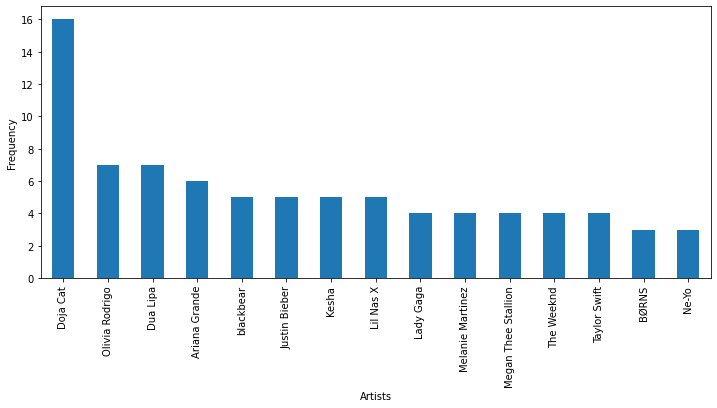

In [649]:
plt.figure(figsize = (12,5))
top_15_artist = song_df.groupby("artist_name").count().sort_values(by="chorus",ascending=False)[:15]
top_15_artist["chorus"].plot(kind = "bar", ylabel= "Frequency", xlabel="Artists")

In [650]:
song_df["chorus"]= song_df["chorus"].apply(lambda x: x.lower().replace("\n", " <newline> "))

In [651]:
#expected punctuation = !"#$%&\'()*+,-./:;=?@[\\]^_`{|}~
punc_list =  string.punctuation
punc_list = punc_list.replace("<", "")
punc_list =punc_list.replace(">", "")

In [652]:
punc_list

'!"#$%&\'()*+,-./:;=?@[\\]^_`{|}~'

In [653]:
song_df["chorus"]= song_df["chorus"].apply(lambda row: row.translate(str.maketrans('', '', punc_list)))

In [654]:
song_df["chorus"]= song_df["chorus"].apply(lambda row: row.translate(str.maketrans('', '', string.digits)))

#### Creating the words frequency dictionary so that words that appears less than determined frequency can be eliminated.

In [655]:
#creating word frequency dictionary 
words_dict = {}
for chorus in song_df.chorus:
    #for row in chorus:
    for word in chorus.split():
    #print(chorus)
    #y = [x.split() for x in chorus]
        if(word in words_dict):
               
            words_dict[word] += 1
        else:
            words_dict[word] = 1


In [656]:
key_max = max(words_dict.keys(), key=(lambda k: words_dict[k]))
key_min = min(words_dict.keys(), key=(lambda k: words_dict[k]))

print("Highest frequency is:" , words_dict[key_max])
print("Lowest frequency is:", words_dict[key_min])

Highest frequency is: 3100
Lowest frequency is: 1


In [1]:
#getting the list of word frequencies in ascending order
#print({k: v for k, v in sorted(words_dict.items(), key=lambda item: item[1], reverse= True)}, "\n")[:10]

In [658]:
wordcloud_dict = words_dict.copy()
entries_to_remove = (stopwords.words('english'))
for k in entries_to_remove:
    wordcloud_dict.pop(k, None)
wordcloud_dict.pop("<newline>", None)
wordcloud_dict.pop("feat", None)
wordcloud_dict.pop("ft", None)
wordcloud_dict.pop("—", None)

(-0.5, 1999.5, 1499.5, -0.5)

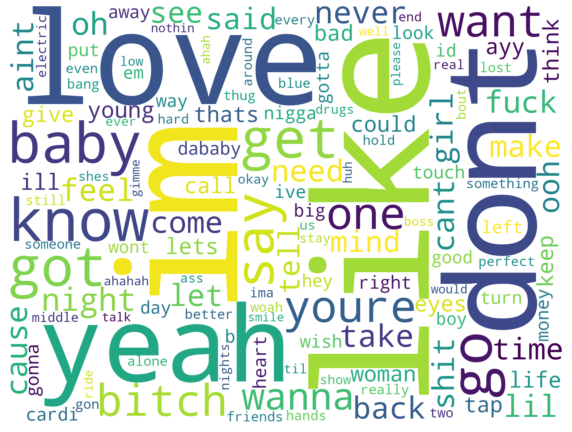

In [774]:
from wordcloud import WordCloud
plt.figure(figsize= (10,10))
wc = WordCloud(background_color="white",width=2000,height=1500, max_words=130,relative_scaling=0.2,normalize_plurals=False).generate_from_frequencies(wordcloud_dict)
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")


In [665]:
#Ignoring words that appears less than 4 times
ignored_words = set()
for k, v in words_dict.items():
    if words_dict[k] < 4:
        ignored_words.add(k)


#### Creating 2D list that contains all songs seperately 

In [666]:
#output format = [[song1], [song2],..[song(n-1)]]
all_songs = []

for chorus in song_df.chorus:
    song = []    
    song.extend(chorus.split())
    all_songs.append(song)

In [2]:
all_songs

### Creating 1D list for tokenization of words in lyrics

In [668]:
#creating list that contains all words seperately
#output model = [word1, word2, ... word(n-1)]
all_words = []

for chorus in song_df.chorus:
    for word in chorus.split():
        all_words.append(word)   


In [1]:
all_words


In [670]:
print('Unique words before ignoring:', len(words_dict.values()))
print('Ignoring words with frequency <', 4)
words = sorted(set(words_dict.keys()) - ignored_words)
print('Unique words after ignoring:', len(words))

word_indices = dict((c, i) for i, c in enumerate(words))
indices_word = dict((i, c) for i, c in enumerate(words))


Unique words before ignoring: 2421
Ignoring words with frequency < 4
Unique words after ignoring: 782


In [671]:
STEP = 1
sentences = []
next_words = []
ignored = 0
SEQUENCE_LEN = 5

for song in all_songs:
    for i in range(0, len(song) - SEQUENCE_LEN, STEP):
        # Only add sequences where no word is in ignored_words
        if len(set(song[i: i+SEQUENCE_LEN+1]).intersection(ignored_words)) == 0:
            
            sentences.append(song[i: i + SEQUENCE_LEN])
            next_words.append(song[i + SEQUENCE_LEN])
        
        else:
            ignored = ignored+1
print('Ignored sequences:', ignored)
print('Remaining sequences:', len(sentences))

Ignored sequences: 8760
Remaining sequences: 12764


In [673]:
X_train, X_test, y_train, y_test = train_test_split(sentences, next_words, random_state=42, test_size=0.2)

In [674]:
import keras
print('Build model...')
model = Sequential()
model.add(Embedding(input_dim=len(words), output_dim=1024))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
model.add(Dense(len(words)))
model.add(Activation('softmax'))

Build model...


In [675]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 1024)        800768    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              1180672   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 782)               200974    
                                                                 
 activation (Activation)     (None, 782)               0         
                                                                 
Total params: 2,182,414
Trainable params: 2,182,414
Non-trainable params: 0
______________________________________________

In [676]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer="adam", 
              metrics=['accuracy'])

In [677]:
def generator(sentence_list, next_word_list, batch_size):
    index = 0
    while True:
        x = np.zeros((batch_size, SEQUENCE_LEN), dtype=np.int32)
        y = np.zeros((batch_size), dtype=np.int32)
        for i in range(batch_size):
            for t, w in enumerate(sentence_list[index % len(sentence_list)]):
                x[i, t] = word_indices[w]
            y[i] = word_indices[next_word_list[index % len(sentence_list)]]
            index = index + 1
        yield x, y


In [678]:
BATCH_SIZE = 64

In [679]:
model.fit(generator(X_train, y_train, BATCH_SIZE),
                    steps_per_epoch=int(len(X_train)/BATCH_SIZE) + 1,
                    epochs=100,
                    #callbacks=callbacks_list,
                    )

Epoch 1/100
160/160 [==============================] - 11s 49ms/step - loss: 5.4731 - accuracy: 0.1419
Epoch 2/100
160/160 [==============================] - 8s 52ms/step - loss: 4.7883 - accuracy: 0.1662
Epoch 3/100
160/160 [==============================] - 8s 51ms/step - loss: 4.2296 - accuracy: 0.2124
Epoch 4/100
160/160 [==============================] - 8s 52ms/step - loss: 3.6315 - accuracy: 0.2848
Epoch 5/100
160/160 [==============================] - 9s 58ms/step - loss: 3.0831 - accuracy: 0.3707
Epoch 6/100
160/160 [==============================] - 12s 74ms/step - loss: 2.6385 - accuracy: 0.4467
Epoch 7/100
160/160 [==============================] - 14s 89ms/step - loss: 2.2643 - accuracy: 0.5124
Epoch 8/100
160/160 [==============================] - 15s 95ms/step - loss: 1.9566 - accuracy: 0.5741
Epoch 9/100
160/160 [==============================] - 12s 78ms/step - loss: 1.7186 - accuracy: 0.6208
Epoch 10/100
160/160 [==============================] - 9s 54ms/step - loss: 

In [680]:
model.save("latest_model")

INFO:tensorflow:Assets written to: latest_model\assets


INFO:tensorflow:Assets written to: latest_model\assets


In [693]:
new_model = load_model('latest_model')

In [171]:
#pred = model.predict(generator(X_test, y_test, BATCH_SIZE))

In [837]:
test_songs = [[342, 144, 0, 342, 144], [316, 21, 324, 397, 0], [726, 30, 472, 550, 0]]
test_songs

[[342, 144, 0, 342, 144], [316, 21, 324, 397, 0], [726, 30, 472, 550, 0]]

In [839]:
num_of_words = 25
i= 1
for song in test_songs:
   
    #first_sentence = np.expand_dims(first_sentence,axis=0)
    print("Song ", i)
    output = " "
    for x in song:
        output += (indices_word[x]) + " "

    for word in range(num_of_words):


        new_predict = new_model.predict(np.expand_dims(song,axis=0))

        output+= indices_word[new_predict.argmax()] + " "
        song= np.append(song,new_predict.argmax())
    new_string = output.replace("<newline>", "\n" )
    i+=1
    print(new_string)



Song  1
 keep dancing 
 keep dancing with you aint keep it up all the moment 
 crash they lost on me on with me off with a bitch 
 off off 
Song  2
 i am in love 
 i love you 
 the heart knows how to say 
 when they like it lost on you 
 you the get it on the 
Song  3
 we are not right 
 cause its all because of you 
 its you its you 
 its all of you 
 its you 
 its you 
 its you 
